In [277]:
import pandas as pd
import numpy as np

ratings='../Data/ml-latest/ratings.csv'

df=pd.read_csv(ratings, usecols=['userId','movieId','rating'],
    dtype={
        'userId':'int32',
        'movieId':'int32',
        'rating':'float32',
        }
    )

In [595]:
import polars as pl

polars=pl.read_csv(ratings, columns=['userId','movieId','rating'],
    dtypes={
        'userId':pl.Int32,
        'movieId':pl.Int32,
        'rating':pl.Float32,
        }
    )

I'm trying out Polars because it's even faster than pandas. Also polars is written in Rust, a language I'd like to improve my skills in.

Polars represents data in memory with Arrow arrays while Pandas represents data in memory in Numpy arrays. Apache Arrow is an emerging standard for in-memory columnar analytics that can accelerate data load times, reduce memory usage and accelerate calculations. https://pola-rs.github.io/polars-book/user-guide/coming_from_pandas.html

In [114]:
polars['rating'].value_counts().sort(by='rating')

rating,counts
f32,u32
0.5,442388
1.0,886233
1.5,441354
2.0,1850627
2.5,1373419
3.0,5515668
3.5,3404360
4.0,7394710
4.5,2373550


In [158]:
# Polars
stars, counts = [(rating) for rating in zip(polars['rating'].value_counts().sort(by='rating'))] # .items() does not work in Polars yet, but will be added

In [159]:
# Pandas
pandas_stars, pandas_counts = zip(*[(x, y) for x, y in df['rating'].value_counts().sort_index().items()])

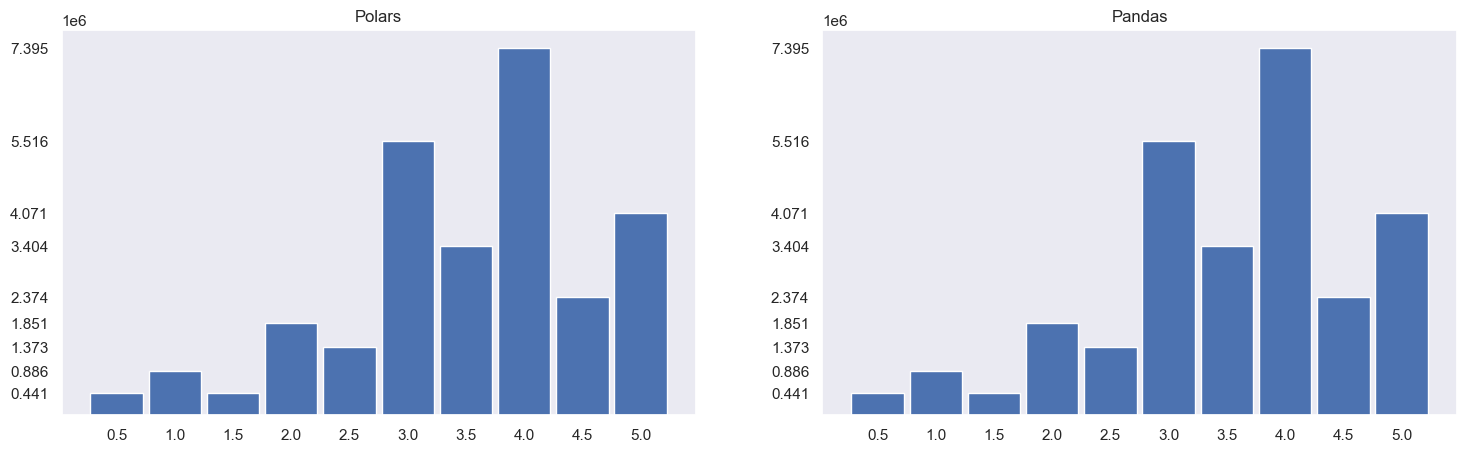

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="dark")

# Average stars for all movies

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5)) # Create a figure with two subplots

# Plot for Polars
ax1.bar(x=stars[0], height=counts[0], width=0.45)
ax1.set_xticks(stars[0])
ax1.set_yticks(counts[0][1::])
ax1.set_title('Polars')

# Plot for Pandas
ax2.bar(x=pandas_stars, height=pandas_counts, width=0.45)
ax2.set_xticks(pandas_stars)
ax2.set_yticks(pandas_counts[1::])
ax2.set_title('Pandas')

plt.show()

Just making sure everything works similar.

Moving on. Some questions I want to answer:

1. What movies have the highest relative ratings for each star category?

2. What movies have the largest deviation from the population mean rating?

Genres

1. What's the genre distribution?

2. Which are the top genres?

In [179]:
# To get relative rating, we have to quantize the data in some way.
# I think maybe creating a function which converts ratings to a relative p-scale with the total sum of 1.

# First we calculate the sum of ratings
total_sum = sum(counts[0])

# Then we make use of list comprehenstion to get probabilities
probabilities = [x/total_sum for x in counts[0]]

sum(probabilities), probabilities

(1.0,
 [0.015939931635151297,
  0.031932361259380995,
  0.015902674997740823,
  0.06668098561029039,
  0.04948643490876303,
  0.1987381457955272,
  0.1226644159910388,
  0.2664429683033212,
  0.08552271927044441,
  0.14668936222834184])

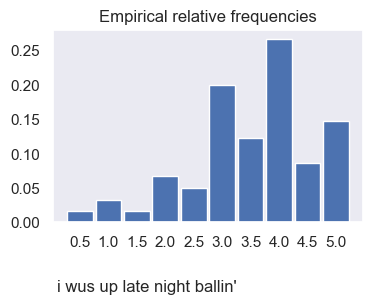

In [211]:
# Average stars for all movies in a 0-1 scale

fig, ax = plt.subplots(figsize=(4, 2.5))

# Plot for Polars
ax.bar(x=stars[0], height=probabilities, width=0.45)
ax.set_xticks(stars[0])
ax.set_title("Empirical relative frequencies")
plt.text(.1,-.1,"i wus up late night ballin'")

plt.show()

I mean we could probably apply PMF somehow. But I've got some other ideas.

In [558]:
def get_ratings(df, mId, pandas=False):
    #TODO: Allow multiple search queries at once (or just... yknow, loop this function)

    # Pandas
    if pandas:
        # Select rows matching with movieId
        selected_rows = df.loc[df['movieId'] == mId]['rating']

        # Get all  ratings for seletion
        pandas_stars, pandas_counts = zip(*[(x, y) for x, y in df['rating'].value_counts().sort_index().items()])

        dist = [x/sum(pandas_counts) for x in pandas_counts]

    # Polars
    else: 
        selected_rows = df.filter(pl.col('movieId') == mId)

        # Get all ratings for selection #TODO: Fix the tuple nesting issue in list comprehension 
        stars, counts = [(rating) for rating in zip(selected_rows['rating'].value_counts().sort(by='rating'))] # very impotant to sort by rating, to get stars in correct order 0.5 to 5.0
        # TODO: If above issue with nested tuple is fixed, below row can be moved to row before return outside this if loop
        dist = [x/sum(counts[0]) for x in counts[0]]

    return dist

In [311]:
%%timeit # Polars time
get_ratings(df=polars, mId=1337)

12.2 ms ± 87.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [312]:
%%timeit # Pandas time
get_ratings(df=df, mId=1337, pandas=True)

230 ms ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [562]:
# get all movie id:s
unique_names = polars['movieId'].unique()
type(unique_names), unique_names.shape

(polars.internals.series.series.Series, (53889,))

## Creating tables - Pandas vs. Polars

In [502]:
df = pl.DataFrame(unique_names) # Convert polars series to polars df

# create new columns with empty floats as initial values (this really isn't necessary, but helps for visualization)
new_columns = np.array(np.arange(0.5, 5.5, 0.5), dtype=str)

for idx, col_name in enumerate(new_columns):
    df = df.with_columns([
        pl.col('movieId'),
        pl.Series(col_name + ' Stars', [0.0], dtype=pl.Float32),
    ])

print(df.head())

shape: (5, 11)
┌─────────┬─────────┬────────────┬───────────┬─────┬───────────┬───────────┬───────────┬───────────┐
│ movieId ┆ 0.5     ┆ 1.0 Stars  ┆ 1.5 Stars ┆ ... ┆ 3.5 Stars ┆ 4.0 Stars ┆ 4.5 Stars ┆ 5.0 Stars │
│ ---     ┆ Stars   ┆ ---        ┆ ---       ┆     ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ i32     ┆ ---     ┆ f32        ┆ f32       ┆     ┆ f32       ┆ f32       ┆ f32       ┆ f32       │
│         ┆ f32     ┆            ┆           ┆     ┆           ┆           ┆           ┆           │
╞═════════╪═════════╪════════════╪═══════════╪═════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1       ┆ 0.0     ┆ 0.0        ┆ 0.0       ┆ ... ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 2       ┆ 0.0     ┆ 0.0        ┆ 0.0       ┆ ... ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 3       ┆ 0.0     ┆ 0.0        ┆ 0.0       ┆ ... ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 4       ┆ 0.0     ┆ 0.0        ┆ 0.0       ┆ ... ┆ 0.0       ┆ 0.0       ┆

In [561]:
# in pandas we can do
movie_names = [1,2,3]

pandas = pd.DataFrame(movie_names)
new_columns = np.array(np.arange(0.5, 5.5, 0.5), dtype=str)

for idx, col_name in enumerate(new_columns):
    pandas[col_name + ' Stars'] = 0.0

pandas.head()

,0,0.5 Stars,1.0 Stars,1.5 Stars,2.0 Stars,2.5 Stars,3.0 Stars,3.5 Stars,4.0 Stars,4.5 Stars,5.0 Stars
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Removing movies with few ratings (polars)

In [568]:
#testing on a smaller sample
pol_sample = unique_names.sample(frac=0.1)

In [571]:
relative_ratings = []

for i in pol_sample:
    relative_rating.append(get_ratings(df=polars, mId=i))

Ok, nice. Now let's fill the table! Let's see. The function get_ratings() ouputs a list, so for every item in the list, we want to add that value to corresponding Star-column we just created.